In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from notebooks.mnist_classifier.mnist_tiny_cnn import TinyCNN

from mixer.mixer import SetMixer
from datasets.distribution_datasets import MultinomialDistributionDataset

from torch.utils.data import DataLoader
from itertools import product

from scipy.linalg import sqrtm
import ternary

In [2]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'stretch' in c['name']]

In [ ]:
def w2_multinom_pairwise(ps):
    # build pop cov matrix
    def pop_cov(x):
        n = len(x)
        c = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                c[i, j] = x[i]*(1 - x[i]) if i == j else -x[i]*x[j]
        return c

    ps = np.array(ps)
    n = len(ps)
    dists = np.zeros((n, n))

    sigs = [pop_cov(p) for p in ps]
    roots = [sqrtm(s) for s in sigs]

    for i in range(n):
        for j in range(n):
            mu_diff = np.sum((ps[i] - ps[j])**2)
            mid = sqrtm(roots[i] @ sigs[j] @ roots[i])
            if np.iscomplexobj(mid):
                mid = mid.real
            cov_diff = np.trace(sigs[i] + sigs[j] - 2*mid)
            dists[i, j] = np.sqrt(mu_diff + cov_diff)

    return dists

In [ ]:
# load + prep dataset
def prepare_dataset(dataset_cfg):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    # dataset.probs = probs
    # dataset.data, _, _ = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

In [ ]:
def simplex_grid(dim, points_per_dim):
    lin = np.linspace(0, 1, points_per_dim)
    grid = np.array(list(product(*([lin] * dim))))
    grid = grid[np.isclose(grid.sum(axis=1), 1)]  # keep only rows that sum to 1
    return grid

In [ ]:
def batched_dists(mixed_sets, mix_probs, encoder, batch_size=8, device='cuda'):

    with torch.no_grad():
        
        zs = []
        for i in range(0, mixed_sets.size(0), batch_size):
            x_chunk = mixed_sets[i:i+batch_size].to(device)
            z_chunk = encoder(x_chunk).cpu()  # offload!
            zs.append(z_chunk)
        z = torch.cat(zs, dim=0).to(device)  # full z back on gpu :)

    return w2_multinom_pairwise(mix_probs), torch.cdist(z, z, p=2)

In [7]:
def plot_ternary(ax, dists, mix_probs, title=None, scale=99):

    prob_tuples = [tuple(map(int, np.round(s * scale))) for s in mix_probs]
    anchor_idx = prob_tuples.index((scale//3, scale//3, scale//3))
    # anchor_idx = 0
    colors = dists[anchor_idx]
    simplex_d = {prob_tuples[i]: colors[i] for i in range(len(prob_tuples))}

    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax.heatmap(simplex_d, style="h", colorbar=False)
    tax.boundary()
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    if title:
        tax.set_title(title)

/tmp/ipykernel_976824/2002123837.py:25: RuntimeWarning: invalid value encountered in sqrt
  dists[i, j] = np.sqrt(mu_diff + cov_diff)


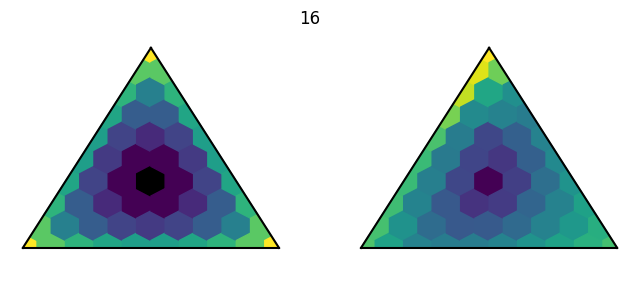

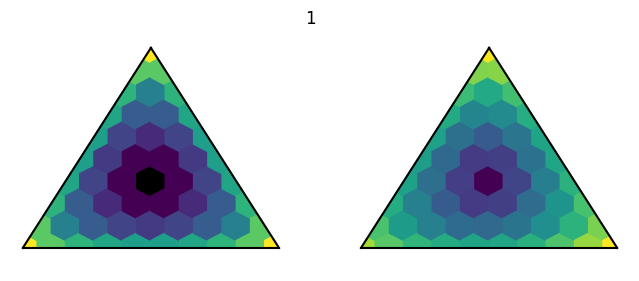

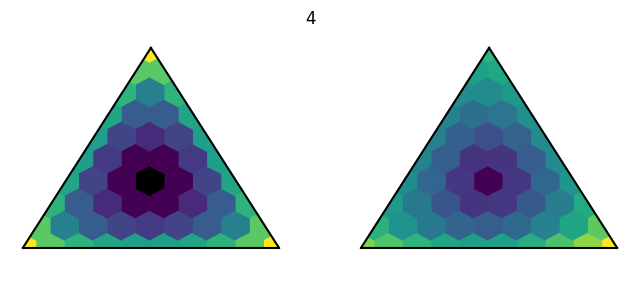

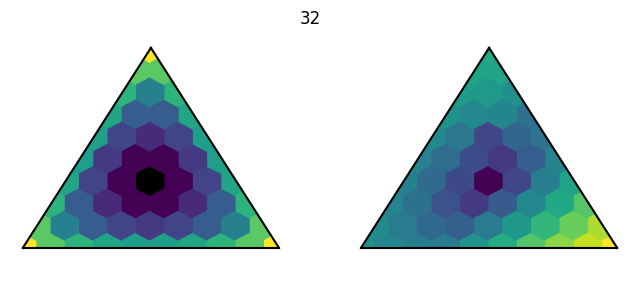

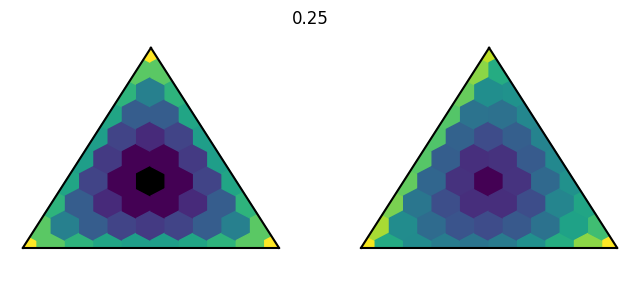

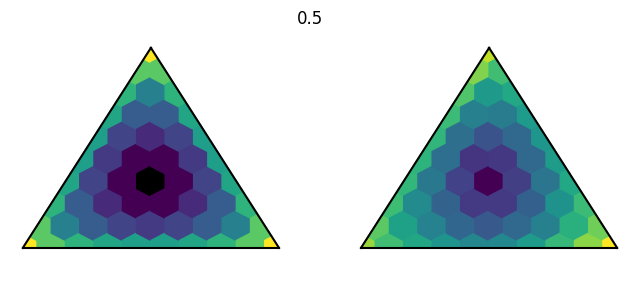

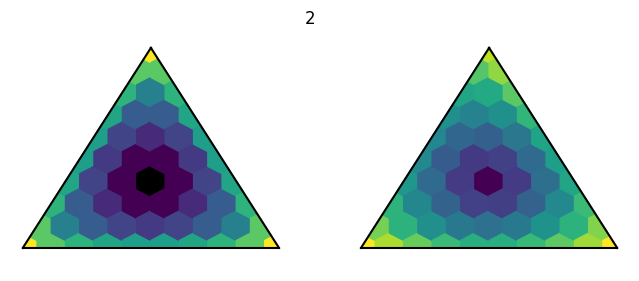

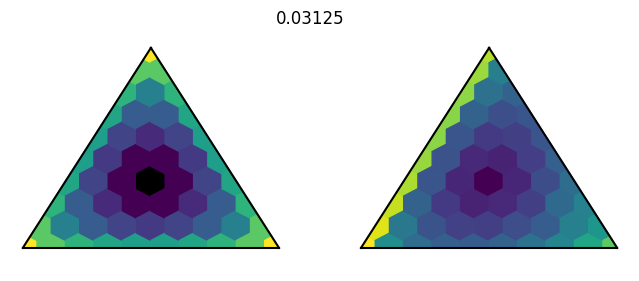

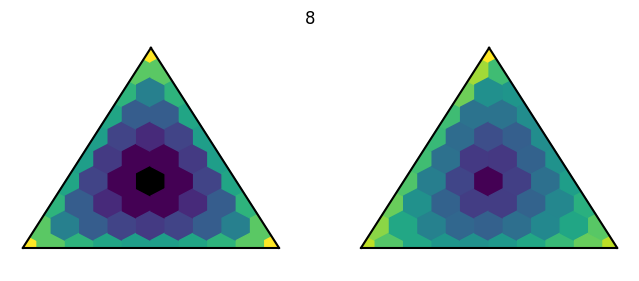

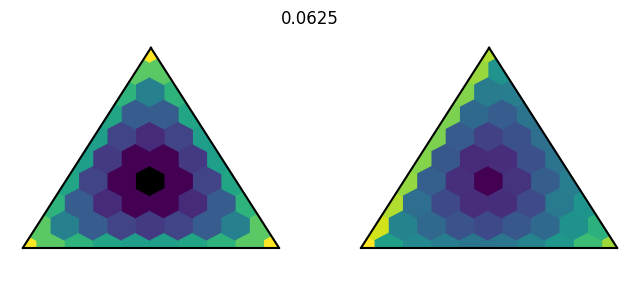

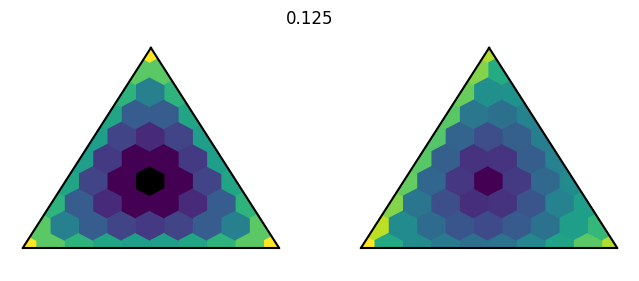

     encoder      corr
0   16.00000  0.894100
1    1.00000  0.969629
2    4.00000  0.954164
3   32.00000  0.802808
4    0.25000  0.932314
5    0.50000  0.950096
6    2.00000  0.957269
7    0.03125  0.812040
8    8.00000  0.947280
9    0.06250  0.882492
10   0.12500  0.925453


In [8]:
corrs = []  # we'll store correlations here :)

points_per_dim = 10
k = 3
set_size = 10000

mix_probs_labels = simplex_grid(k, points_per_dim)
n_sets = len(mix_probs_labels)

dataset = MultinomialDistributionDataset(data_shape=(k,), n_sets=n_sets, set_size=5000,
                                            custom_probs=mix_probs_labels)
mixed_sets = torch.tensor(dataset.data).to(torch.float).to('cuda')

for idx in range(len(cfg)):
    
    name = cfg[idx]['config']['dataset']['spike']

    encoder, _ = load_model(cfg[idx]['config'], cfg[idx]['dir'], 'cuda')

    # get distance !
    w, l = batched_dists(mixed_sets, mix_probs_labels, encoder)

    # plot it  :)
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    fig.suptitle(name)
    plot_ternary(axs[0], w, mix_probs_labels, scale=9)
    plot_ternary(axs[1], l.cpu(), mix_probs_labels, scale=9)
    plt.show()

    np.save('numerical_results/alpha_%s_dists.npy'%str(name), l.cpu().numpy())

    # correlate!
    w_flat, l_flat = torch.tensor(w.flatten()), l.flatten().cpu()
    mask = ~torch.isnan(w_flat) & ~torch.isnan(l_flat)
    if mask.sum() > 1:
        corr = torch.corrcoef(torch.stack([w_flat[mask], l_flat[mask]]))[0, 1].item()
    else:
        corr = float('nan')  # if too few points, set as nan
    corrs.append({'encoder': name, 'corr': corr})

corr_table = pd.DataFrame(corrs)
print(corr_table)


In [9]:
corr_table[r'$1-\text{corr}$'] = 1- corr_table['corr']
corr_table[r'$\alpha_1$'] = corr_table['encoder']

(0.0, 0.2055331161818816)

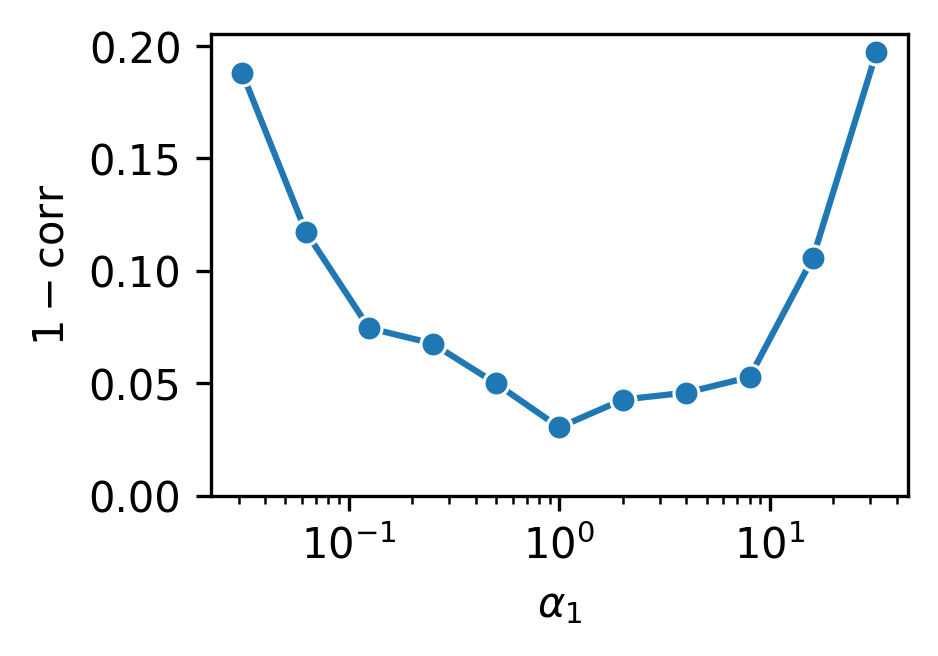

In [10]:
fig = plt.figure(figsize=(3,2), dpi=300)

sns.lineplot(corr_table, marker='o', y=r'$1-\text{corr}$', x=r'$\alpha_1$')
plt.xscale('log')
plt.ylim(0)

/tmp/ipykernel_976824/3479544514.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


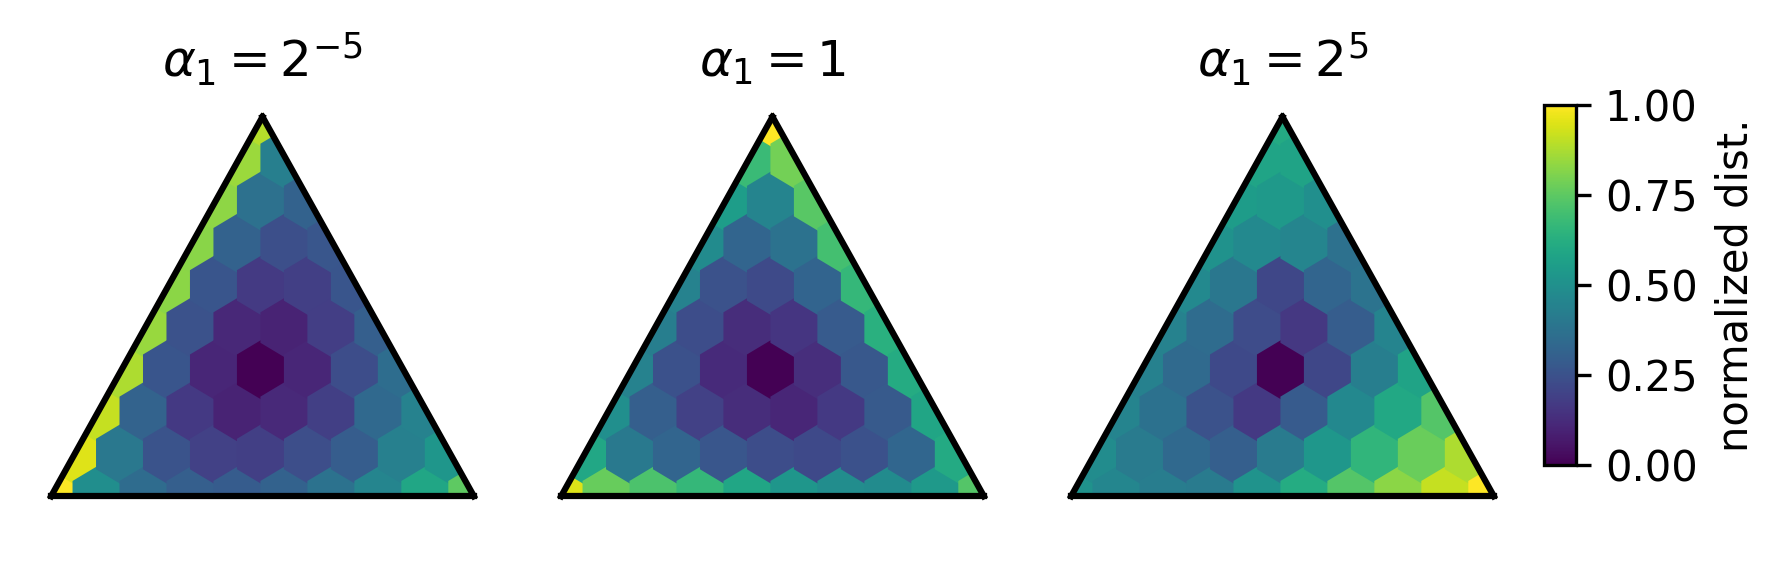

In [11]:

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 3, figsize=(21/4, 2), dpi=300)  # 1 row, 4 plots :)

norm = Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('viridis')  # or any other!

asmall = np.load('numerical_results/alpha_0.03125_dists.npy')
a1 = np.load('numerical_results/plain_multinomial_DistributionEncoderGNN_dists.npy')
abig = np.load('numerical_results/alpha_32_dists.npy')

# plot them in order: w, plain, mnist, dna
# plot_ternary(axs[0], w, mix_probs_labels, scale=9, title=r'analytical $W_2$')
plot_ternary(axs[0], asmall, mix_probs_labels, scale=9, title=r'$\alpha_1 = 2^{-5}$')
plot_ternary(axs[1], a1, mix_probs_labels, scale=9, title=r'$\alpha_1 = 1$')
plot_ternary(axs[2], abig, mix_probs_labels, scale=9, title=r'$\alpha_1 = 2^5$')

plt.subplots_adjust(right=0.96)

# add vertical colorbar in the freed-up space
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar_ax = fig.add_axes([0.99, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
fig.colorbar(sm, cax=cbar_ax, label='normalized dist.')

plt.tight_layout()
plt.show()